In [188]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [159]:
precios_fondo = pd.read_csv('0P00001RTN Historical Data.csv').iloc[:, :2]
precios_fondo.head()

,Date,Price
0,Feb 24,718.93
1,Jan 24,691.74
2,Dec 23,677.38
3,Nov 23,641.32
4,Oct 23,612.42


In [160]:
precios_fondo['Date'] = precios_fondo['Date'].astype(str)
precios_fondo['Date'] = pd.to_datetime(precios_fondo['Date'], format='%b %y', errors='coerce').dt.strftime('%Y-%m')
precios_fondo.head()

,Date,Price
0,2024-02,718.93
1,2024-01,691.74
2,2023-12,677.38
3,2023-11,641.32
4,2023-10,612.42


In [161]:
precios_index = precios_fondo.set_index('Date')
precios_index.columns = ['fondo']
precios_index.head()

,fondo
Date,
2024-02,718.93
2024-01,691.74
2023-12,677.38
2023-11,641.32
2023-10,612.42


In [162]:
precios_benchmark = pd.read_csv('MSCI World Health Care Net USD Historical Data.csv').iloc[:, :2]
precios_benchmark.head()

,Date,Price
0,02/01/2024,534.10
1,01/01/2024,522.33
2,12/01/2023,508.67
3,11/01/2023,487.12
4,10/01/2023,460.70


In [163]:
precios_benchmark['Date'] = precios_benchmark['Date'].astype(str)
precios_benchmark['Date'] = pd.to_datetime(precios_benchmark['Date'], format='%m/%d/%Y', errors='coerce').dt.strftime('%Y-%m')
precios_benchmark.head()

,Date,Price
0,2024-02,534.10
1,2024-01,522.33
2,2023-12,508.67
3,2023-11,487.12
4,2023-10,460.70


In [164]:
precios_benchmark = precios_benchmark.set_index('Date')
precios_benchmark.columns = ['mkt']
precios_benchmark.head()

,mkt
Date,
2024-02,534.10
2024-01,522.33
2023-12,508.67
2023-11,487.12
2023-10,460.70


In [165]:
print(precios_benchmark.index.equals(precios_index.index))

True


In [166]:
precios = pd.concat([precios_index, precios_benchmark], axis=1, join='inner')
precios.head()

,fondo,mkt
Date,,
2024-02,718.93,534.10
2024-01,691.74,522.33
2023-12,677.38,508.67
2023-11,641.32,487.12
2023-10,612.42,460.70


In [167]:
precios.shape

(62, 2)

In [168]:
precios = precios.dropna()
precios.shape

(62, 2)

In [169]:
precios.index = pd.to_datetime(precios.index)
precios.head()

,fondo,mkt
Date,,
2024-02-01,718.93,534.10
2024-01-01,691.74,522.33
2023-12-01,677.38,508.67
2023-11-01,641.32,487.12
2023-10-01,612.42,460.70


In [170]:
precios = precios.sort_index(axis=0)
precios.head()

,fondo,mkt
Date,,
2019-01-01,401.35,325.16
2019-02-01,413.39,331.57
2019-03-01,414.13,334.40
2019-04-01,399.97,325.78
2019-05-01,392.73,317.97


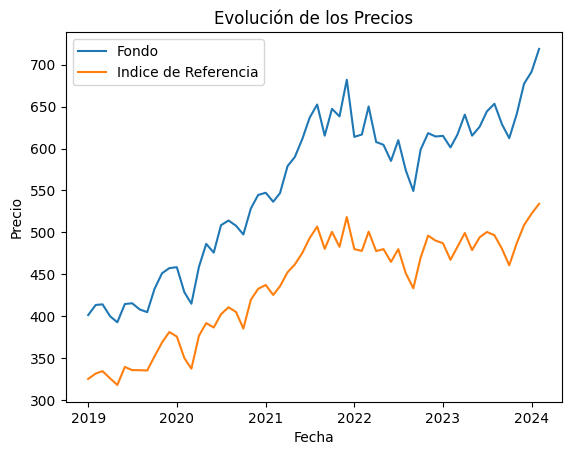

In [190]:
plt.plot(precios.index, precios['fondo'], '-', label='Fondo')
plt.plot(precios.index, precios['mkt'], '-', label='Indice de Referencia')
plt.title('Evolución de los Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()

In [171]:
retornos = np.log(precios).diff().dropna()
retornos.head()

,fondo,mkt
Date,,
2019-02-01,0.029558,0.019522
2019-03-01,0.001788,0.008499
2019-04-01,-0.034790,-0.026116
2019-05-01,-0.018267,-0.024265
2019-06-01,0.053951,0.065311


In [172]:
factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3)
factors.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [173]:
factors.columns = ['date', 'mkt-rf', 'smb', 'hml', 'rf']
factors.head()

,date,mkt-rf,smb,hml,rf
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [174]:
factors['date'] = factors['date'].astype(str)
factors = factors[factors['date'].str.len() == 6]
factors.head()

,date,mkt-rf,smb,hml,rf
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [175]:
factors['date'] = pd.to_datetime(factors['date'],format='%Y%m', errors='coerce').dt.strftime("%Y-%m")
factors.head()

,date,mkt-rf,smb,hml,rf
0,1926-07,2.96,-2.56,-2.43,0.22
1,1926-08,2.64,-1.17,3.82,0.25
2,1926-09,0.36,-1.40,0.13,0.23
3,1926-10,-3.24,-0.09,0.70,0.32
4,1926-11,2.53,-0.10,-0.51,0.31


In [176]:
factors = factors.set_index('date')
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


In [177]:
factors = factors.loc['2019-02':'2024-02']
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02,3.40,2.05,-2.67,0.18
2019-03,1.10,-3.05,-4.17,0.19
2019-04,3.97,-1.74,2.15,0.21
2019-05,-6.94,-1.32,-2.37,0.21
2019-06,6.93,0.29,-0.71,0.18


In [178]:
factors.index = pd.to_datetime(factors.index)
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,3.40,2.05,-2.67,0.18
2019-03-01,1.10,-3.05,-4.17,0.19
2019-04-01,3.97,-1.74,2.15,0.21
2019-05-01,-6.94,-1.32,-2.37,0.21
2019-06-01,6.93,0.29,-0.71,0.18


In [179]:
factors.tail()

,mkt-rf,smb,hml,rf
date,,,,
2023-10-01,-3.19,-3.87,0.19,0.47
2023-11-01,8.84,-0.02,1.64,0.44
2023-12-01,4.87,6.34,4.93,0.43
2024-01-01,0.71,-5.09,-2.38,0.47
2024-02-01,5.06,-0.24,-3.48,0.42


In [180]:
factors = factors.apply(pd.to_numeric, errors='coerce').div(100)
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,0.0340,0.0205,-0.0267,0.0018
2019-03-01,0.0110,-0.0305,-0.0417,0.0019
2019-04-01,0.0397,-0.0174,0.0215,0.0021
2019-05-01,-0.0694,-0.0132,-0.0237,0.0021
2019-06-01,0.0693,0.0029,-0.0071,0.0018


In [181]:
factors['mkt-rf'] = retornos['mkt'] - factors['rf']
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,0.017722,0.0205,-0.0267,0.0018
2019-03-01,0.006599,-0.0305,-0.0417,0.0019
2019-04-01,-0.028216,-0.0174,0.0215,0.0021
2019-05-01,-0.026365,-0.0132,-0.0237,0.0021
2019-06-01,0.063511,0.0029,-0.0071,0.0018


In [182]:
excess_returns = retornos['fondo'] - factors['rf']
excess_returns.head()

Date
2019-02-01    0.027758
2019-03-01   -0.000112
2019-04-01   -0.036890
2019-05-01   -0.020367
2019-06-01    0.052151
dtype: float64

In [183]:
factors = factors.drop('rf', axis=1)
factors.head()

,mkt-rf,smb,hml
date,,,
2019-02-01,0.017722,0.0205,-0.0267
2019-03-01,0.006599,-0.0305,-0.0417
2019-04-01,-0.028216,-0.0174,0.0215
2019-05-01,-0.026365,-0.0132,-0.0237
2019-06-01,0.063511,0.0029,-0.0071


In [184]:
factors = sm.add_constant(factors)
factors.head()

,const,mkt-rf,smb,hml
date,,,,
2019-02-01,1.0,0.017722,0.0205,-0.0267
2019-03-01,1.0,0.006599,-0.0305,-0.0417
2019-04-01,1.0,-0.028216,-0.0174,0.0215
2019-05-01,1.0,-0.026365,-0.0132,-0.0237
2019-06-01,1.0,0.063511,0.0029,-0.0071


In [185]:
apt_model = sm.OLS(excess_returns, factors).fit()

print(apt_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     197.2
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           4.66e-30
Time:                        19:19:42   Log-Likelihood:                 181.81
No. Observations:                  61   AIC:                            -355.6
Df Residuals:                      57   BIC:                            -347.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.050      0.2